# Alpha Excel v2.0 - 간단한 예제

간단한 모멘텀 전략으로 알파 시그널 생성부터 백테스트까지 한번에 실행해봅니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from alpha_excel2.core.facade import AlphaExcel

## 1. 초기화

In [2]:
ae = AlphaExcel(
    start_time='2016-01-28',
    end_time='2025-09-30',
    universe=None,
    config_path='../config'
)

print(f"Time Range: {ae._start_time} to {ae._end_time}")

Time Range: 2016-01-28 00:00:00 to 2025-09-30 00:00:00


## 2. 사용 가능한 연산자 확인

In [3]:
o = ae.ops

by_category = o.list_operators_by_category()
for category, ops in sorted(by_category.items()):
    print(f"\n{category}:")
    for op in ops:
        print(f"  - {op}")


arithmetic:
  - abs
  - add
  - divide
  - multiply
  - negate
  - power
  - subtract

crosssection:
  - rank

group:
  - group_count
  - group_max
  - group_min
  - group_neutralize
  - group_rank
  - group_sum

logical:
  - and
  - equal
  - greater_or_equal
  - greater_than
  - less_or_equal
  - less_than
  - not
  - not_equal
  - or

timeseries:
  - ts_all
  - ts_any
  - ts_arg_max
  - ts_arg_min
  - ts_corr
  - ts_count_nans
  - ts_covariance
  - ts_delay
  - ts_delta
  - ts_max
  - ts_mean
  - ts_min
  - ts_product
  - ts_std_dev
  - ts_sum


## 3. 데이터 로딩

In [ ]:
f = ae.field

cap = f('fnguide_market_cap')
ret = f('returns')
sector = f('fnguide_industry_group')

print("[시가총액 샘플]")
print(cap.to_df().iloc[:10, :5])

[Market Cap Sample]
symbol           A000020       A000030       A000040       A000050  \
date                                                                 
2016-01-28  2.457970e+11  5.854160e+12  2.094930e+11  5.277440e+11   
2016-01-29  2.536180e+11  5.948800e+12  2.103690e+11  5.483050e+11   
2016-02-01  2.628350e+11  5.975840e+12  2.051100e+11  5.359690e+11   
2016-02-02  2.558520e+11  5.955560e+12  2.024800e+11  5.537880e+11   
2016-02-03  2.656280e+11  5.800080e+12  2.059870e+11  5.565300e+11   
2016-02-04  2.572490e+11  5.948800e+12  2.086160e+11  5.551590e+11   
2016-02-05  2.656280e+11  6.070480e+12  2.094930e+11  5.647550e+11   
2016-02-11  2.404900e+11  5.806840e+12  1.972210e+11  5.633840e+11   
2016-02-12  2.153520e+11  5.766280e+12  1.937150e+11  5.579010e+11   
2016-02-15  2.242900e+11  5.955560e+12  2.007270e+11  5.387100e+11   

symbol           A000060  
date                      
2016-01-28  1.557656e+12  
2016-01-29  1.584147e+12  
2016-02-01  1.589445e+12  
2016

## 4. 시그널 생성: 모멘텀 + 섹터 내 순위

In [ ]:
# 이동평균 계산
ma3 = o.ts_mean(ret, window=3, record_output=True)
ma5 = o.ts_mean(ret, window=5)

# 모멘텀 = ma3 - ma5
momentum = ma3 - ma5

# 섹터 내 순위
signal = o.group_rank(momentum, sector)

print("[시그널 생성 완료]")
print(signal.to_df().iloc[:10, :5])

[Signal Generated]
symbol       A000020   A000030   A000040   A000050   A000060
date                                                        
2016-01-28       NaN       NaN       NaN       NaN       NaN
2016-01-29       NaN       NaN       NaN       NaN       NaN
2016-02-01  0.503704  0.541667  0.503704  0.504762  0.533333
2016-02-02  0.629630  0.750000  0.170370  0.952381  0.666667
2016-02-03  0.481481  0.750000  0.340741  0.647619  0.666667
2016-02-04  0.170370  0.500000  0.755556  0.647619  0.466667
2016-02-05  0.822222  0.333333  0.888889  0.447619  0.733333
2016-02-11  0.385185  0.666667  0.185185  0.314286  0.666667
2016-02-12  0.244444  0.500000  0.214815  0.914286  0.600000
2016-02-15  0.125926  0.333333  0.429630  0.495238  0.866667


## 5. 백테스트: 가중치 변환 및 수익률 계산

In [ ]:
# 스케일러 설정 (DollarNeutral)
ae.set_scaler('DollarNeutral')

# 시그널 -> 가중치
weights = ae.to_weights(signal)

# 포트폴리오 수익률
port_returns = ae.to_portfolio_returns(weights)
long_returns = ae.to_long_returns(weights)
short_returns = ae.to_short_returns(weights)

print("[백테스트 완료]")

[Backtest Complete]


## 6. 누적 수익률 그래프

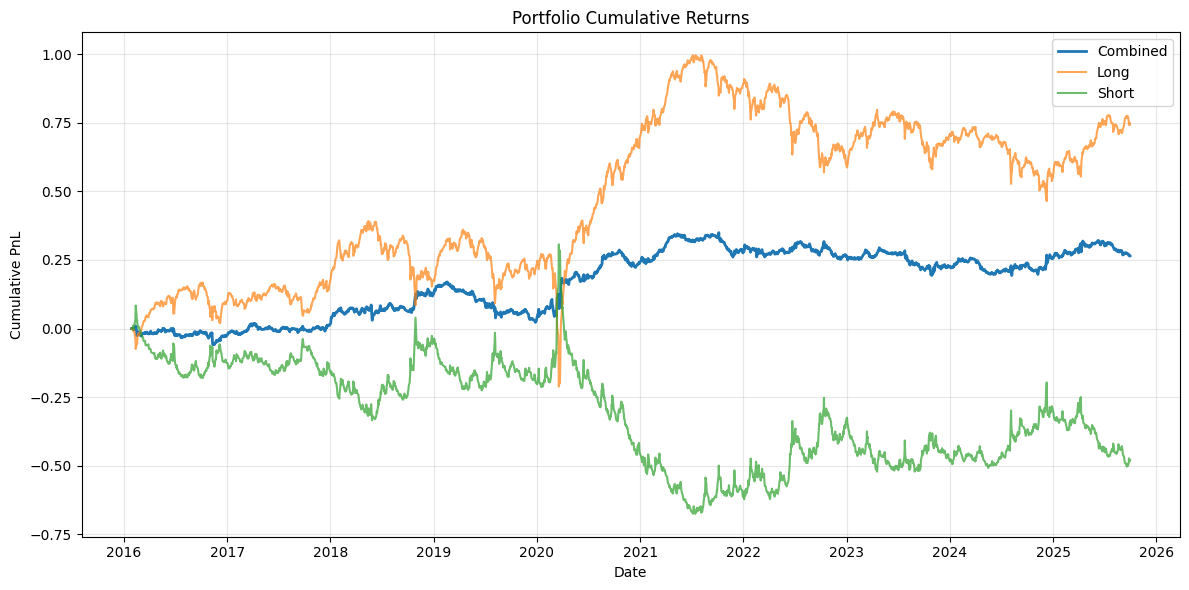

In [ ]:
# 일별 수익률 합산
daily_pnl = port_returns.to_df().sum(axis=1)
long_daily_pnl = long_returns.to_df().sum(axis=1)
short_daily_pnl = short_returns.to_df().sum(axis=1)

# 누적 수익률
cum_pnl = daily_pnl.cumsum()
long_cum_pnl = long_daily_pnl.cumsum()
short_cum_pnl = short_daily_pnl.cumsum()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(cum_pnl.index, cum_pnl.values, label='전체', linewidth=2)
plt.plot(long_cum_pnl.index, long_cum_pnl.values, label='롱', linewidth=1.5, alpha=0.7)
plt.plot(short_cum_pnl.index, short_cum_pnl.values, label='숏', linewidth=1.5, alpha=0.7)
plt.xlabel('날짜')
plt.ylabel('누적 수익')
plt.title('포트폴리오 누적 수익률')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. 성과 지표

In [ ]:
# 성과 지표 계산
annualized_return = daily_pnl.mean() * 252
annualized_std = daily_pnl.std() * np.sqrt(252)
sharpe_ratio = daily_pnl.mean() / daily_pnl.std() * np.sqrt(252)

print("[성과 지표]")
print(f"연율화 수익률: {annualized_return:.4f} ({annualized_return*100:.2f}%)")
print(f"연율화 변동성: {annualized_std:.4f} ({annualized_std*100:.2f}%)")
print(f"샤프 비율: {sharpe_ratio:.2f}")
print(f"\n총 수익률: {cum_pnl.iloc[-1]:.4f} ({cum_pnl.iloc[-1]*100:.2f}%)")
print(f"최대 낙폭: {(cum_pnl - cum_pnl.cummax()).min():.4f}")

[Performance Metrics]
Annualized Return: 0.0281 (2.81%)
Annualized Volatility: 0.0819 (8.19%)
Sharpe Ratio: 0.34

Total Return: 0.2649 (26.49%)
Max Drawdown: -0.1562
